# AntsBees 

# TypeB: DataSet Class

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [ ]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [ ]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/AntsBees')

In [ ]:
'''
2. 前処理クラスの定義
'''
class ImageTransform():
    '''画像の前処理クラス。訓練時、検証時で異なる動作をする。

    Attributes:
      data_transform(dic):
        train: 訓練用のトランスフォーマーオブジェクト
        val  : 検証用のトランスフォーマーオブジェクト
    '''

    def __init__(self, resize, mean, std):
        '''トランスフォーマーオブジェクトを生成する。

        Parameters:
        resize(int): リサイズ先の画像の大きさ
        mean(tuple): (R, G, B)各色チャネルの平均値
        std        : (R, G, B)各色チャネルの標準偏差
        '''
        # dicに訓練用、検証用のトランスフォーマーを生成して格納
        self.data_transform = {
            'train': transforms.Compose([
                # ランダムにトリミングする
                transforms.RandomResizedCrop(
                    resize, # トリミング後の出力サイズ
                    scale=(0.5, 1.0)),  # スケールの変動幅
                transforms.RandomHorizontalFlip(p = 0.5),  # 0.5の確率で左右反転
                transforms.RandomRotation(15),  # 15度の範囲でランダムに回転
                transforms.ToTensor(),          # Tensorオブジェクトに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeでトリミング
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        '''オブジェクト名でコールバックされる
        Parameters:
          img: 画像
          phase(str): 'train'または'val' 前処理のモード
        '''
        return self.data_transform[phase](img) # phaseはdictのキー


### 前処理前後の画像を確認する


In [ ]:
tt='hymenoptera_data/'+'train'+'/bees/2405441001_b06c36fa72.jpg'
image_file_path = os.path.join(data_dir,tt)
print(image_file_path)

/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg


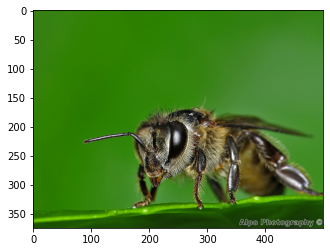

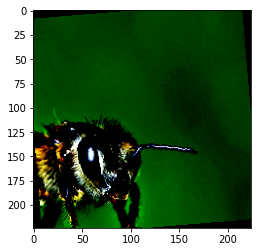

In [ ]:

%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/3100226504_c0d4f1e3f1.jpg')
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済み画像の表示
# モデルの入力サイズ(タテ・ヨコ)
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用

# トランスフォーマーオブジェクトを生成
transform = ImageTransform(SIZE, MEAN, STD)
# 訓練モードの前処理を適用、torch.Size([3, 224, 224])
img_transformed = transform(img, phase="train")

# (色、高さ、幅)を (高さ、幅、色)に変換
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# ピクセル値を0～1の範囲に制限して表示
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

#(1) DataSet の作成

### train_list, val_list の作成

In [ ]:
import glob
import pprint
from collections import namedtuple
import os


CandidateInfoTuple = namedtuple('CandidateInfoTuple', ['label','path'])


def make_datapath_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    candidateInfo_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        p=Path(path)
        label=p.parts[-2]
        if label == 'ants':
          label = 1 # Ants:1
        else:
           label =0 #Bees:0

        candidateInfo_list.append(
            CandidateInfoTuple(
                label,
                path
            )           
        )

    return candidateInfo_list



# ファイルパスのリストを生成
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

file_list={'train':train_list,'val':val_list}

print(train_list)
print(len(train_list))

# 訓練データのファイルパスの前後5要素ずつ出力
print('train')
pprint.pprint(train_list[:5])
pprint.pprint(train_list[-6:-1])
# 検証データのファイルパスの前後5要素ずつ出力
print('val')
pprint.pprint(val_list[:5])
pprint.pprint(val_list[-6:-1])

[CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/0013035.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/116570827_e9c126745d

In [ ]:
ants_list = [nt for nt in train_list if not nt.label]        
bees_list = [nt for nt in train_list if nt.label]
print(ants_list)

[CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/0013035.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg'), CandidateInfoTuple(label=0, path='/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/116570827_e9c126745d

In [ ]:
import random 

class MakeBalancedDataset(data.Dataset):
    '''
    アリとハチの画像のDatasetクラス
    PyTorchのDatasetクラスを継承

    Attributes:
      file_list(list): 画像のパスを格納したリスト
      transform(object): 前処理クラスのインスタンス
      phase(str): 'train'または'val'
    Returns:
      img_transformed: 前処理後の画像データ
      label(int): 正解ラベル
    '''
    def __init__(self, file_list, ratio_int=1, transform=None, phase='train',records=300):
        '''インスタンス変数の初期化
        '''
        self.file_list = file_list[phase]  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase          # 'train'または'val'
        self.ratio_int= ratio_int
        self.records=records

        random.shuffle(self.file_list)
        
        self.ants_list = [nt for nt in self.file_list if not nt.label]        
        self.bees_list = [nt for nt in self.file_list if nt.label]

    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.ants_list)
            random.shuffle(self.bees_list)

    def __len__(self):
        if self.ratio_int:
            return self.records
        else:
            return len(self.file_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)
            #奇数のとき
            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.ants_list)
                candidateInfo_tup = self.ants_list[neg_ndx]
            #偶数のとき
            else:
                pos_ndx %= len(self.bees_list)
                candidateInfo_tup = self.bees_list[pos_ndx]
        else:
            candidateInfo_tup = self.file_list[ndx]

        # ファイルを開く -> (高さ, 幅, RGB)
        img = Image.open(candidateInfo_tup.path)

        # 画像を前処理  -> torch.Size([3, 224, 224])
        img_transformed = self.transform(
            img, self.phase)        

        return img_transformed, candidateInfo_tup.label

### train_dataset, val_dataset の作成

In [ ]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 32
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeBalancedDataset(
    file_list=file_list, # 訓練データのファイルパス
    ratio_int=True,
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    records=300,
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeBalancedDataset(
    file_list=file_list, # 検証データのファイルパス
    ratio_int=True,
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    records=200,
    phase='val')


In [ ]:
print(len(train_dataset))
print(len(val_dataset))

300
200


#END